In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Пример без лагов

In [51]:
# Создаем синтетические данные
np.random.seed(50)
n_samples = 10000

# Рейтинги (пример порядка)
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']
company_types = ['bank', 'oil', 'tech', 'retail', 'telecom']

data = pd.DataFrame({
    'rating': np.random.choice(ratings, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_samples, freq='D'),
    'company_type': np.random.choice(company_types, size=n_samples),
    'inn': np.random.randint(1000,2000, size=n_samples)  # просто случайные ИНН
})

In [53]:
# ① Кодируем рейтинг (ординально, если есть порядок)
rating_order = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC', 'D']  # от лучшего к худшему
encoder = OrdinalEncoder(categories=[rating_order])
data['rating_encoded'] = encoder.fit_transform(data[['rating']])

# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# ③ Категориальные фичи (One-Hot для типа компании)
data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')

# Удаляем ненужные столбцы
data = data.drop(['inn', 'date'], axis=1)

In [59]:
# Фичи и целевая переменная
X = data.drop(['rating', 'rating_encoded'], axis=1)
y = data['rating_encoded']

# Разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Обучаем Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Предсказания
y_pred = model.predict(X_test)

# Оценка
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=rating_order))

Accuracy: 0.11
              precision    recall  f1-score   support

         AAA       0.10      0.11      0.11       298
         AA+       0.11      0.12      0.11       310
          AA       0.17      0.15      0.16       337
         BBB       0.14      0.13      0.13       372
         BB+       0.12      0.13      0.13       344
          BB       0.08      0.08      0.08       346
           B       0.09      0.10      0.10       317
         CCC       0.11      0.10      0.10       347
           D       0.11      0.10      0.10       329

    accuracy                           0.11      3000
   macro avg       0.11      0.11      0.11      3000
weighted avg       0.11      0.11      0.11      3000



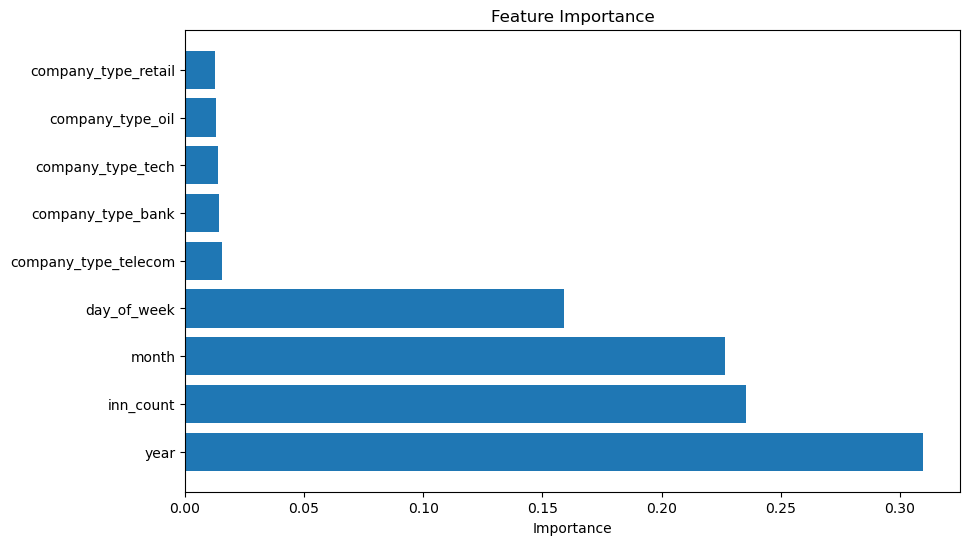

In [60]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

Пример с лагами

In [153]:
np.random.seed(42)
n_companies = 500  # 50 компаний
n_months = 24     # 2 года данных (24 месяца)
n_samples = 10000
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
data = pd.DataFrame({
    'inn': np.random.randint(1000,2000, size=n_samples),
    'date': pd.date_range(start='2020-01-01', periods=n_months, freq='ME').tolist() * n_companies,
    'rating': np.random.choice(ratings, size=n_companies * n_months, p=[0.1, 0.2, 0.3, 0.2, 0.1, 0.05, 0.03, 0.02])
})
print(data['inn'].unique())

ValueError: All arrays must be of the same length

In [339]:
np.random.seed(42)
n_companies = 5000
n_months = 24
ratings = ['AAA', 'AA+', 'AA', 'BBB', 'BB+', 'BB', 'B', 'CCC']
rating_probs = [0.1, 0.15, 0.15, 0.15, 0.1, 0.1, 0.15, 0.1]

# Создаем компании с разными характеристиками
companies = pd.DataFrame({
    'inn': np.random.randint(1000, 2000, size=n_companies),
    'company_type': np.random.choice(['bank', 'oil', 'tech', 'retail', 'manufacturing'], size=n_companies),
    'base_rating': np.random.choice(ratings, size=n_companies, p=rating_probs)
})

# Генерируем временные ряды для каждой компании
data = []
for _, company in companies.iterrows():
    dates = pd.date_range(start='2020-01-01', periods=n_months, freq='ME')
    base_rating_idx = ratings.index(company['base_rating'])
    
    # Генерируем рейтинги с некоторой динамикой
    rating_idxs = np.clip(
        base_rating_idx + np.cumsum(np.random.normal(0, 0.3, n_months)).round().astype(int),
        0, len(ratings)-1
    )
    company_ratings = [ratings[i] for i in rating_idxs]
    
    data.extend([{
        'inn': company['inn'],
        'date': date,
        # 'company_type': company['company_type'],
        'rating': rating,
        'months_since_start': i
    } for i, (date, rating) in enumerate(zip(dates, company_ratings))])

data = pd.DataFrame(data)

In [340]:
# ② Временные фичи
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day_of_week'] = data['date'].dt.dayofweek

# # ③ Категориальные фичи (One-Hot для типа компании)
# data = pd.get_dummies(data, columns=['company_type'])

# ④ Агрегаты по ИНН (пример: сколько раз встречается компания)
data['inn_count'] = data.groupby('inn')['inn'].transform('count')


In [341]:
# --- 2. Добавляем лаги рейтинга ---
data = data.sort_values(['inn', 'date'])

for lag in [1, 3, 6, 12]:
    data[f'rating_lag_{lag}'] = data.groupby('inn')['rating'].shift(lag)

# Удаляем строки с NaN (где нет истории)
data = data.dropna()


In [342]:
# --- 3. Правильное кодирование ---
# Создаем словарь для ручного кодирования
rating_to_code = {rating: i for i, rating in enumerate(rating_order)}

# Применяем кодирование ко всем столбцам с рейтингами
data['rating_encoded'] = data['rating'].map(rating_to_code)
for lag in [1, 3, 6, 12]:
    col = f'rating_lag_{lag}'
    data[col] = data[col].map(rating_to_code)
# Разница с предыдущим рейтингом
data['rating_diff_1'] = data.groupby('inn')['rating_encoded'].diff(1).fillna(0)
# print(data['rating_diff_1'].unique())

In [343]:
# --- 4. Фичи и обучение ---
# X = data.filter(like='lag_')  # Только лаги
# y = data['rating_encoded']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestClassifier(n_estimators=200, random_state=42)
# model.fit(X_train, y_train)
exclude_cols = ['inn', 'date', 'rating', 'rating_encoded']
X = data.drop(exclude_cols, axis=1)
y = data['rating_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 4. Обучение модели ---
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # Для несбалансированных данных
)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

In [348]:
# --- 5. Оценка ---
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred, target_names=rating_order))

# Важность фичей
pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

Accuracy: 0.93
              precision    recall  f1-score   support

         AAA       0.94      0.96      0.95      2870
         AA+       0.91      0.88      0.90      2752
          AA       0.91      0.92      0.91      2908
         BBB       0.92      0.93      0.92      3098
         BB+       0.93      0.92      0.92      2617
          BB       0.93      0.93      0.93      2503
           B       0.92      0.93      0.92      2343
         CCC       0.96      0.95      0.96      2536

    accuracy                           0.93     21627
   macro avg       0.93      0.93      0.93     21627
weighted avg       0.93      0.93      0.93     21627



,feature,importance
9,rating_diff_1,0.393479
5,rating_lag_1,0.231621
8,rating_lag_12,0.152974
7,rating_lag_6,0.106477
4,inn_count,0.084968
6,rating_lag_3,0.016229
0,months_since_start,0.007095
2,month,0.003707
3,day_of_week,0.002009
1,year,0.001441


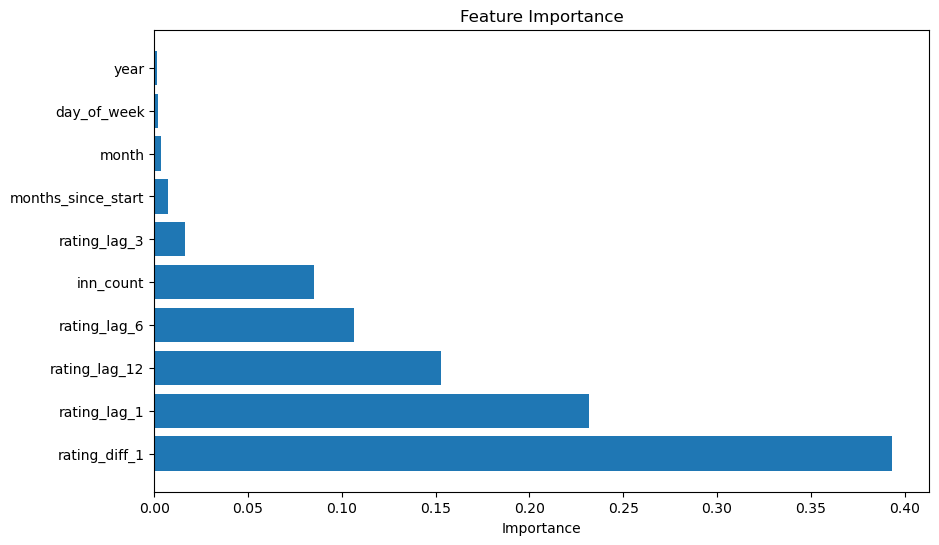

In [349]:
import matplotlib.pyplot as plt

# Важность фичей
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

# График
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()